In [2]:
# prediction utils 
import os
import yaml
import rasterio
import numpy as np 
import pandas as pd 
import dask.dataframe as dd
from catboost import CatBoostRegressor, Pool
from glob import glob
from rasterio.transform import from_origin

def write_raster(raster_path, data, metadata, block_size=256):
  height, width = data.shape
  dtype = data.dtype

  with rasterio.open(
      raster_path,
      'w',
      driver='GTiff',
      height=height,
      width=width,
      count=1,
      dtype=dtype,
      crs=metadata['crs'],
      transform=metadata['transform'],  # Use the original transform
      tiled=True,  # Enable tiling
      compress='lzw',
      blockxsize=block_size,  # Set block size for x
      blockysize=block_size   # Set block size for y
  ) as dst:
      for i in range(0, height, block_size):
          for j in range(0, width, block_size):
              # Calculate the block size
              block_height = min(block_size, height - i)
              block_width = min(block_size, width - j)
              
              # Extract the block
              block = data[i:i+block_height, j:j+block_width]
              
              # Write the block
              dst.write(block, 1, window=((i, i+block_height), (j, j+block_width)))


def load_yaml(file_path, keys_to_keep=None):
    with open(file_path, 'r') as file:
        data = yaml.safe_load(file)
    if keys_to_keep:
        data = {key: data[key] for key in keys_to_keep if key in data}
    return data

def load_patch_to_df(paths, names):
    arrays = []
    min_size = None
    for path in paths:
        with rasterio.open(path) as src:
            array = src.read(1).flatten()  # Read the first band and flatten it
            if min_size is None:
                min_size = array.size
            else:
                min_size = min(min_size, array.size)
            arrays.append(array)
    # Truncate arrays to the minimum size found
    arrays = [array[:min_size] for array in arrays]
    stacked_arrays = np.column_stack(arrays)
    new_df = pd.DataFrame(stacked_arrays, columns=names)
    return new_df

In [3]:
# prediction config
model_dir = "/home/ljp238/Documents/projectx/Oct1516/models"
tilename = "N13E103"
yaml_path = "/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/*/*.yaml"
model_patt = "/home/ljp238/Documents/projectx/Oct1516/models/*/*.cbm"
fcolydi = 'ldtm'
fcolyda = 'zdifa'
fcolyds = 'zdifs'
fcolref = 'tdem_dem_filled'
fcolX = ['egm08', 'egm96', 'tdem_hem', fcolref]  # ,'edem_demw84','edem_dem']
fcolY = [fcolydi, fcolyda, fcolyds]
FTCOLSC = fcolX + [fcolydi]  # fcolYc ,
keys_to_keep = FTCOLSC

In [9]:
yaml_files = glob(yaml_path)
yaml_file = [i for i in yaml_files if tilename in i][0]
ydict_f = load_yaml(yaml_file, keys_to_keep=keys_to_keep)
paths = list(ydict_f.values())
names = list(ydict_f.keys())
paths,names

(['/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_EGM08.tif',
  '/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_EGM96.tif',
  '/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_tdem_HEM.tif',
  '/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_tdem_DEM_EF_filled.tif',
  '/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_multi_DTM_LiDAR.tif'],
 ['egm08', 'egm96', 'tdem_hem', 'tdem_dem_filled', 'ldtm'])

In [10]:
# that's a problem as -9999 was exlcuded in the training, find a way to include
#pdf.head()

In [12]:
roi = 'tsap'

In [14]:
# try pickle if model size still an issue
model_files = glob(model_patt)
models_list = [i for i in model_files if roi in i]
model_files, models_list

(['/home/ljp238/Documents/projectx/Oct1516/models/tsap/ctb_tsap_ldtm_100_4_GPU.cbm',
  '/home/ljp238/Documents/projectx/Oct1516/models/tsap/ctb_tsap_zdifs_100_4_GPU.cbm',
  '/home/ljp238/Documents/projectx/Oct1516/models/tsap/ctb_tsap_zdifa_100_4_GPU.cbm'],
 ['/home/ljp238/Documents/projectx/Oct1516/models/tsap/ctb_tsap_ldtm_100_4_GPU.cbm',
  '/home/ljp238/Documents/projectx/Oct1516/models/tsap/ctb_tsap_zdifs_100_4_GPU.cbm',
  '/home/ljp238/Documents/projectx/Oct1516/models/tsap/ctb_tsap_zdifa_100_4_GPU.cbm'])

In [15]:
pdf =  load_patch_to_df(paths, names)
pdf[fcolyds] = pdf[fcolref].subtract(pdf[fcolydi])
pdf[fcolyda] = pdf[fcolref].add(pdf[fcolydi])

In [ ]:
ndf = pd.DataFrame()  # New DataFrame to store predictions
raster_out_list = []
for fcolYr in fcolY:
  print(fcolYr)
  modelpaths = [i for i in models_list if fcolYr in i]
  for modelpath in modelpaths:
      try:
          print(f'Passed: {modelpath}')
          model = CatBoostRegressor()
          model.load_model(modelpath)

          a = modelpath.split('_')[1]
          MLname = f'{fcolYr}ML_{a}'
          print(MLname)

          # Prepare data for prediction
          Xpdf = pdf.drop(fcolY, axis=1)
          prediction = model.predict(Xpdf)

          # Add prediction to new DataFrame
          ndf[MLname] = prediction

          # Find the raster path
          raster_path = next((path for path in paths if path.endswith('tdem_DEM_clean_filled.tif')), None)
          print(raster_path)

          # Get metadata from the raster file
          with rasterio.open(raster_path) as src:
              metadata = src.meta

          # Define output raster path
          raster_out = raster_path.replace('.tif', f'_{MLname}.tif')
          raster_out_list.append(raster_out)

          # Reshape prediction to match raster dimensions
          width, height = metadata['width'], metadata['height']  # Ensure these match the original raster
          reshaped_data = prediction.reshape((height, width))

          # Write the raster
          write_raster(raster_out, reshaped_data, metadata)

      except Exception as e:
          print(f'Failed {modelpath}: {e}')
          pass

# Join the original DataFrame with the new DataFrame containing predictions
result_df = pd.concat([pdf, ndf], axis=1)

In [73]:
# remove both datasets in training and also save the name of features in the dem
# there is a leakage from the LidAR
# add extra step of downsampig with DT,RF, LGB or other 1-1 mapping 

In [18]:
ldtm_fpath = "/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_tdem_DEM_clean_filled_ldtmML_tsap.tif"
zaml_fpath = "/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_tdem_DEM_clean_filled_zdifaML_tsap.tif"
zsml_fpath = "/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_tdem_DEM_clean_filled_zdifsML_tsap.tif"
tdem_fpath = "/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_edem_W84.tif"

In [ ]:
zaml_fpath,zsml_fpath,tdem_fpath
# load zaml, zsml, tdem form their paths 
# do tdem - zaml and save as raster  py replace(.tif, ._tdem_zaml.tif) from zaml fpath 
# do tdem + zaml 
# do tdem - zsml
# do tdem + zsml

# and save them as well like the ones above?

In [19]:
# Function to save a new raster file
def save_raster(output_path, data, profile):
  with rasterio.open(output_path, 'w', **profile) as dst:
      dst.write(data, 1)

# Open the raster files
with rasterio.open(zaml_fpath) as zaml_src, \
   rasterio.open(zsml_fpath) as zsml_src, \
   rasterio.open(tdem_fpath) as tdem_src:

  # Read the data
  zaml = zaml_src.read(1)
  zsml = zsml_src.read(1)
  tdem = tdem_src.read(1)

  # Get the profile for saving new rasters
  profile = tdem_src.profile

  # Perform operations
  tdem_minus_zaml = tdem - zaml
  tdem_plus_zaml = tdem + zaml
  tdem_minus_zsml = tdem - zsml
  tdem_plus_zsml = tdem + zsml

  # Save the results
  save_raster(zaml_fpath.replace('.tif', '._tdem_minus_zaml.tif'), tdem_minus_zaml, profile) # nop:
  save_raster(zaml_fpath.replace('.tif', '._tdem_plus_zaml.tif'), tdem_plus_zaml, profile) #maybe::no
  save_raster(zsml_fpath.replace('.tif', '._tdem_minus_zsml.tif'), tdem_minus_zsml, profile) # yep:dxk
  save_raster(zsml_fpath.replace('.tif', '._tdem_plus_zsml.tif'), tdem_plus_zsml, profile) # nop

In [56]:
pdf.head()

,egm08,egm96,tdem_hem,tdem_dem_filled,ldtm,zdif
0,-23.967974,-24.179001,0.322996,21.149900,-9999.0,10020.149414
1,-23.967674,-24.178772,0.320104,20.300865,-9999.0,10019.300781
2,-23.967375,-24.178545,0.252271,20.002047,-9999.0,10019.001953
3,-23.967073,-24.178316,0.236024,19.860840,-9999.0,10018.861328
4,-23.966774,-24.178089,0.235798,19.920370,-9999.0,10018.919922


In [ ]:
# if it does not work save the new df as parquet and write rasters diffly

In [20]:
import rasterio
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import os

coarse_fpath = "/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_tdem_DEM_clean_filled_zdifsML_tsap._tdem_minus_zsml.tif"
fine_fpath = "/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_tdem_DEM_EF_filled.tif"

# Function to save a new raster file
def save_raster(output_path, data, profile):
  with rasterio.open(output_path, 'w', **profile) as dst:
      dst.write(data, 1)

# Open the raster files
with rasterio.open(coarse_fpath) as coarse_src, \
   rasterio.open(fine_fpath) as fine_src:

  # Read the data
  coarse_data = coarse_src.read(1)
  fine_data = fine_src.read(1)

  # Get the profile for saving new rasters
  profile = fine_src.profile

  # Reshape data for model input
  X = coarse_data.flatten().reshape(-1, 1)
  y = fine_data.flatten()

  # Train DecisionTreeRegressor
  decision_tree = DecisionTreeRegressor()
  decision_tree.fit(X, y)
  predicted_fine_decision = decision_tree.predict(X).reshape(fine_data.shape)

  # Train RandomForestRegressor
  random_forest = RandomForestRegressor()
  random_forest.fit(X, y)
  predicted_fine_random = random_forest.predict(X).reshape(fine_data.shape)

  # Save the results
  save_raster(coarse_fpath.replace('.tif', '_DecisionRegressor.tif'), predicted_fine_decision, profile)
  save_raster(coarse_fpath.replace('.tif', '_RandomForestRegressor.tif'), predicted_fine_random, profile)

In [2]:
import rasterio
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

def load_raster(file_path):
  with rasterio.open(file_path) as src:
      data = src.read(1)
      profile = src.profile
  return data, profile

def save_raster(output_path, data, profile):
  with rasterio.open(output_path, 'w', **profile) as dst:
      dst.write(data, 1)

def train_and_predict(model, X, y, shape):
  model.fit(X, y)
  predictions = model.predict(X).reshape(shape)
  return predictions

In [1]:
def save_raster_chunked(output_path, data, profile, chunk_size=1024):
  """
  Save raster data to a file in chunks to improve performance.

  :param output_path: Path to the output raster file.
  :param data: Numpy array containing the raster data.
  :param profile: Rasterio profile for the output file.
  :param chunk_size: Size of the chunks to write at a time.
  """
  height, width = data.shape
  profile.update(height=height, width=width)

  with rasterio.open(output_path, 'w', **profile) as dst:
      for i in range(0, height, chunk_size):
          for j in range(0, width, chunk_size):
              # Define the window to write
              window = rasterio.windows.Window(j, i, min(chunk_size, width - j), min(chunk_size, height - i))
              # Write the data for the current window
              dst.write(data[i:i + window.height, j:j + window.width], 1, window=window)

In [1]:
ml_fpath = "/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_tdem_DEM_clean_filled_zdifsML_tsap._tdem_minus_zsml.tif"
fine_fpath = "/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_tdem_DEM_EF_filled.tif"
mlcoarse_fpath = ml_fpath.replace('tif', '_coarse.tif')

In [ ]:
# this very slow, just do a gdal one to 90m or 30m 

In [17]:
1/3600

0.0002777777777777778

In [27]:
#given 
# 1 arc-second for global coverage (~30 meters) a = 1/3600  and b= 30m # 0.0002777777777777778
# 3 arc-seconds for global coverage (~90 meters) a =? b = 90m a = 1/1200 # 0.0008333333333333334
# 1/9 arc-second (approximately 3 m) resolution b = 3m
# find a

def calculate_arc_seconds(b):
  """
  Calculate the arc-seconds for a given resolution in meters.

  Parameters:
  - b: float, resolution in meters.

  Returns:
  - a: float, resolution in arc-seconds.
  """
  # Constant derived from the relationship
  k = 1 / 120

  # Calculate arc-seconds
  a = k / b

  return a

# Example usage
resolution_30m = 30
resolution_90m = 90

arc_seconds_30m = calculate_arc_seconds(resolution_30m)
arc_seconds_90m = calculate_arc_seconds(resolution_90m)

print(f"Arc-seconds for 30 meters resolution: {arc_seconds_30m}")
print(f"Arc-seconds for 90 meters resolution: {arc_seconds_90m}")

Arc-seconds for 30 meters resolution: 0.0002777777777777778
Arc-seconds for 90 meters resolution: 9.259259259259259e-05


In [24]:
# when you solve the fraction should be equal to degree or very close indeed
#given 
# 1 arc-second for global coverage (~30 meters) a = 1/3600  and b= 30m #@ d= 0.0002777777777777778
# 3 arc-seconds for global coverage (~90 meters) a =? b = 90m a = 1/1200 #@d= 0.0008333333333333334
# 1/9 arc-second (approximately 3 m) resolution b = 3m

In [25]:
from fractions import Fraction

def calculate_arc_seconds(b):
  """
  Calculate the arc-seconds for a given resolution in meters.

  Parameters:
  - b: float, resolution in meters.

  Returns:
  - a: float, resolution in arc-seconds.
  - a_fraction: Fraction, resolution in arc-seconds as a fraction.
  """
  # Constant derived from the relationship
  k = 1 / 3600 * 30  # This ensures the relationship is consistent with 30m = 1/3600 arc-seconds

  # Calculate arc-seconds
  a = k / b

  # Convert to fraction
  a_fraction = Fraction(a).limit_denominator()

  return a, a_fraction

# Example usage
resolution_30m = 30
resolution_90m = 90
resolution_3m = 3

arc_seconds_30m, arc_seconds_30m_fraction = calculate_arc_seconds(resolution_30m)
arc_seconds_90m, arc_seconds_90m_fraction = calculate_arc_seconds(resolution_90m)
arc_seconds_3m, arc_seconds_3m_fraction = calculate_arc_seconds(resolution_3m)

print(f"Arc-seconds for 30 meters resolution: {arc_seconds_30m} (Fraction: {arc_seconds_30m_fraction})")
print(f"Arc-seconds for 90 meters resolution: {arc_seconds_90m} (Fraction: {arc_seconds_90m_fraction})")
print(f"Arc-seconds for 3 meters resolution: {arc_seconds_3m} (Fraction: {arc_seconds_3m_fraction})")

Arc-seconds for 30 meters resolution: 0.0002777777777777778 (Fraction: 1/3600)
Arc-seconds for 90 meters resolution: 9.259259259259259e-05 (Fraction: 1/10800)
Arc-seconds for 3 meters resolution: 0.002777777777777778 (Fraction: 1/360)


In [28]:
1/1200

0.0008333333333333334

In [ ]:
# coarse raster without changing dimensions but only the pixel size # gdal

def coarsen_raster(ml_fpath, mlcoarse_fpath):
    # use gdal to couse raster 

# oml_fpath
Dimensions	X: 9001 Y: 9001 Bands: 1
Origin	102.9999444444444379,14.0000555555555550
Pixel Size	0.0001111111111111111164,-0.0001111111111111111164

# mlcoarse_fpath
Dimensions	X: 9001 Y: 9001 Bands: 1
Origin	102.9999444444444379,14.0000555555555550
Pixel Size	1/1200,-1/1200

In [4]:
# resample ml_fpath by multipltyng the current resolution by 2 and save as mlcoarse_fpath
# the idea is to make the raster coarser, if scale_factor =1, means the same, if 2, then 2 times coarse, if n then n times coarser

def coarsen_raster(ml_fpath, mlcoarse_fpath):
    # use gdal to couse raster 



coarsen_raster(ml_fpath, mlcoarse_fpath)

In [62]:
from osgeo import gdal

def coarsen_raster(ml_fpath, mlcoarse_fpath):
  """
  Coarsen a raster by changing the pixel size without altering dimensions.

  Parameters:
  - ml_fpath: str, path to the input raster file.
  - mlcoarse_fpath: str, path to save the coarsened raster file.
  """
  # Open the input raster
  dataset = gdal.Open(ml_fpath, gdal.GA_ReadOnly)
  if not dataset:
      raise FileNotFoundError(f"Unable to open {ml_fpath}")

  # Get the original geotransform
  geotransform = list(dataset.GetGeoTransform())

  # Modify the pixel size in the geotransform
  geotransform[1] = 1 / 1200  # New pixel width
  geotransform[5] = -1 / 1200  # New pixel height

  # Create a new raster with the same dimensions and data type
  driver = gdal.GetDriverByName('GTiff')
  out_dataset = driver.Create(
      mlcoarse_fpath,
      dataset.RasterXSize,
      dataset.RasterYSize,
      dataset.RasterCount,
      dataset.GetRasterBand(1).DataType
  )

  # Set the new geotransform and copy the projection
  out_dataset.SetGeoTransform(geotransform)
  out_dataset.SetProjection(dataset.GetProjection())

  # Copy the data from the original raster
  for band_index in range(1, dataset.RasterCount + 1):
      in_band = dataset.GetRasterBand(band_index)
      out_band = out_dataset.GetRasterBand(band_index)
      data = in_band.ReadAsArray()
      out_band.WriteArray(data)

  # Flush and close datasets
  out_dataset.FlushCache()
  del out_dataset
  del dataset


coarsen_raster(ml_fpath, mlcoarse_fpath)

In [63]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

def plot_rasters(original_path, resampled_path):
  """
  Plot the original and resampled rasters side by side with colorbars.

  Parameters:
  - original_path: str, path to the original raster file.
  - resampled_path: str, path to the resampled raster file.
  """
  # Open the original and resampled rasters
  with rasterio.open(original_path) as src_orig, rasterio.open(resampled_path) as src_resampled:
      # Read the first band of each raster
      orig_data = src_orig.read(1)
      resampled_data = src_resampled.read(1)

      # Calculate the 10th and 80th percentiles for color scaling
      orig_vmin, orig_vmax = np.percentile(orig_data, [10, 80])
      resampled_vmin, resampled_vmax = np.percentile(resampled_data, [10, 80])

      # Create a figure with two subplots
      fig, axes = plt.subplots(1, 2, figsize=(12, 6))

      # Plot the original raster
      orig_img = axes[0].imshow(orig_data, cmap='terrain', vmin=orig_vmin, vmax=orig_vmax)
      axes[0].set_title('Original Raster')
      fig.colorbar(orig_img, ax=axes[0], orientation='vertical', shrink=0.7)

      # Plot the resampled raster
      resampled_img = axes[1].imshow(resampled_data, cmap='terrain', vmin=resampled_vmin, vmax=resampled_vmax)
      axes[1].set_title('Resampled Raster')
      fig.colorbar(resampled_img, ax=axes[1], orientation='vertical', shrink=0.7)

      # Adjust layout
      plt.tight_layout()
      plt.show()


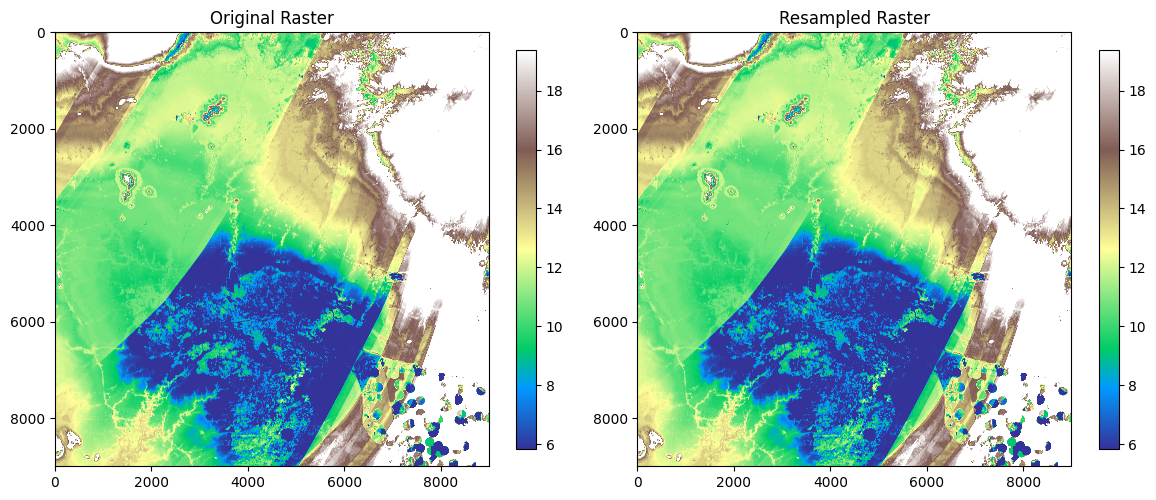

In [64]:
from osgeo import gdal

def coarsen_raster(ml_fpath):
  """
  Coarsen a raster by changing the pixel size without altering dimensions.

  Parameters:
  - ml_fpath: str, path to the input raster file.
  - mlcoarse_fpath: str, path to save the coarsened raster file.
  """
  # Open the input raster
  mlcoarse_fpath = ml_fpath.replace('.tif', '_COARSE.tif')
  dataset = gdal.Open(ml_fpath, gdal.GA_ReadOnly)
  if not dataset:
      raise FileNotFoundError(f"Unable to open {ml_fpath}")

  # Get the original geotransform
  geotransform = list(dataset.GetGeoTransform())

  # Modify the pixel size in the geotransform
  geotransform[1] = 1 / 1200  # New pixel width
  geotransform[5] = -1 / 1200  # New pixel height

  # Create a new raster with the same dimensions and data type
  driver = gdal.GetDriverByName('GTiff')
  out_dataset = driver.Create(
      mlcoarse_fpath,
      dataset.RasterXSize,
      dataset.RasterYSize,
      dataset.RasterCount,
      dataset.GetRasterBand(1).DataType
  )

  # Set the new geotransform and copy the projection
  out_dataset.SetGeoTransform(geotransform)
  out_dataset.SetProjection(dataset.GetProjection())

  # Copy the data from the original raster
  for band_index in range(1, dataset.RasterCount + 1):
      in_band = dataset.GetRasterBand(band_index)
      out_band = out_dataset.GetRasterBand(band_index)
      data = in_band.ReadAsArray()
      out_band.WriteArray(data)

  # Flush and close datasets
  out_dataset.FlushCache()
  del out_dataset
  del dataset
  return mlcoarse_fpath

# modify this fucnction to accept the resolution to coarsen
coarsen_raster(ml_fpath, mlcoarse_fpath)
plot_rasters(ml_fpath, mlcoarse_fpath)

In [65]:
from pyspatialml import Raster
#ml_fpath = "/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_tdem_DEM_clean_filled_zdifsML_tsap._tdem_minus_zsml.tif"
f_filepath = "/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_tdem_DEM_EF_filled.tif"
# compare x,y,z and z only approah 

In [70]:
import numpy as np
import rasterio
from rasterio.enums import Resampling

def resample_raster(input_raster_path, output_raster_path, scale_factor, resampling_method='average'):
  """
  Resample a raster from fine resolution to coarse resolution.

  Parameters:
  - input_raster_path: str, path to the input raster file.
  - output_raster_path: str, path to save the resampled raster file.
  - scale_factor: int, factor by which to downsample the raster.
  - resampling_method: str, method of resampling ('average', 'sum', etc.).

  Returns:
  - None, saves the resampled raster to the specified output path.
  """
  with rasterio.open(input_raster_path) as src:
      # Calculate the new shape
      new_height = src.height // scale_factor
      new_width = src.width // scale_factor

      # Read the data
      data = src.read(
          out_shape=(src.count, new_height, new_width),
          resampling=Resampling[resampling_method]
      )

      # Scale image transform
      transform = src.transform * src.transform.scale(
          (src.width / data.shape[-1]),
          (src.height / data.shape[-2])
      )

      # Update metadata
      metadata = src.meta.copy()
      metadata.update({
          'height': new_height,
          'width': new_width,
          'transform': transform
      })

      # Write the resampled raster to a new file
      with rasterio.open(output_raster_path, 'w', **metadata) as dst:
          dst.write(data)




In [73]:
fc_fpath = "/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_tdem_DEM_clean_filled_zdifsML_tsap._tdem_minus_zsml.tif"
f_filepath = "/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_tdem_DEM_EF_filled.tif"
c_filepath = ml_fpath.replace('tif', '_coarse.tif')
resample_raster(input_raster_path=fc_fpath, output_raster_path=c_filepath, 
                scale_factor=3, resampling_method='bilinear')

In [74]:
import numpy as np
import rasterio
from lightgbm import LGBMRegressor

# Load NDVI data (high resolution) and thermal data (low resolution)
def load_raster(file_path):
  with rasterio.open(file_path) as src:
      return src.read(1), src.transform

ndvi_data, ndvi_transform = load_raster(f_filepath)
thermal_data, thermal_transform = load_raster(c_filepath)

# Resample thermal data to match NDVI resolution
def resample_raster(data, src_transform, dst_transform, dst_shape):
  with rasterio.vrt.WarpedVRT(
      rasterio.open(c_filepath),
      transform=dst_transform,
      height=dst_shape[0],
      width=dst_shape[1],
      resampling=rasterio.enums.Resampling.bilinear
  ) as vrt:
      return vrt.read(1)

thermal_resampled = resample_raster(thermal_data, thermal_transform, ndvi_transform, ndvi_data.shape)

# Flatten the arrays and remove NaN values for regression
ndvi_flat = ndvi_data.flatten()
thermal_flat = thermal_resampled.flatten()

mask = ~np.isnan(ndvi_flat) & ~np.isnan(thermal_flat)
ndvi_flat = ndvi_flat[mask]
thermal_flat = thermal_flat[mask]

# Perform regression using LightGBM
model = LGBMRegressor()
model.fit(ndvi_flat.reshape(-1, 1), thermal_flat)

# Apply the model to high-resolution NDVI data
predicted_thermal = model.predict(ndvi_data.flatten().reshape(-1, 1))
predicted_thermal_image = predicted_thermal.reshape(ndvi_data.shape)

# Save the high-resolution thermal image
def save_raster(data, transform, file_path):
  with rasterio.open(
      file_path,
      'w',
      driver='GTiff',
      height=data.shape[0],
      width=data.shape[1],
      count=1,
      dtype=data.dtype,
      crs='+proj=latlong',
      transform=transform
  ) as dst:
      dst.write(data, 1)

save_raster(predicted_thermal_image, ndvi_transform, 'predicted_thermal_10m.tif')

# this downscalling is performing better at tonlesap loacation 2
# make a diagram of my workflow to include this 

#try cnn based all both images should be filled?

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.191780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 81018001, number of used features: 1
[LightGBM] [Info] Start training from score 14.555402


In [ ]:
# can only over predict or underpredict by certain maginuted, and never get to no bias
# study where under and where over predicting for mekong delta 

In [ ]:
# hlper inverslty proporpional to target, just multiply by -1
# how to sharpen, if the correlation is strong enough or convert the other layer to -1 to 1 like nvdi 


In [35]:
# donwnscale egm08 follow verbate the art and then apply mine with thresolding::
# art, and then find my folder in drive with everything 

In [38]:
iterfpath = cpath = "/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_EGM08.tif"
basefpath = fpath = "/media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_tdem_DEM_EF_filled.tif"

In [40]:
import subprocess
import os

def coarsen_tiff(iterfpath, xres=1/1200, yres=-1/1200):
  # Construct the output file path
  output_path = iterfpath.replace('.tif', '_COARSE.tif')
  
  # Construct the GDAL command
  gdal_command = [
      'gdalwarp',
      '-tr', str(xres), str(yres),  # Set the target resolution
      iterfpath,  # Input file path
      output_path  # Output file path
  ]
  
  # Execute the GDAL command
  try:
      subprocess.run(gdal_command, check=True)
      print(f"Coarsening completed. Output saved to {output_path}")
  except subprocess.CalledProcessError as e:
      print(f"An error occurred: {e}")
  
  # Return the output file path
  return output_path
# need to keep the size of dem the same, and change pixel size arrangent! possible , see above 

In [58]:
basefpath_c = coarsen_tiff(basefpath)
iterfpath_c = coarsen_tiff(iterfpath)

Creating output file that is 1200P x 1200L.
Using internal nodata values (e.g. -9999) for image /media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_tdem_DEM_EF_filled.tif.
Copying nodata values from source /media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_tdem_DEM_EF_filled.tif to destination /media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_tdem_DEM_EF_filled_COARSE.tif.
Processing /media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_tdem_DEM_EF_filled.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Coarsening completed. Output saved to /media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_tdem_DEM_EF_filled_COARSE.tif
Creating output file that is 1200P x 1200L.
Using internal nodata values (e.g. -9999) for image /media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets_TILES12/N13E103/N13E103_EGM08.tif.
Copying nodata values from source /media/ljp238/12TBWolf/ARCHIEVE/ZOUT/datasets

In [44]:
cpaths = [basefpath_c,iterfpath_c]
cnames = ['base', 'iter']
cds = Raster(cpaths)

In [46]:
cdf = cds.to_pandas()

In [48]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440000 entries, 0 to 1439999
Data columns (total 4 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   x                                  1440000 non-null  float64
 1   y                                  1440000 non-null  float64
 2   N13E103_tdem_DEM_EF_filled_COARSE  1362221 non-null  float64
 3   N13E103_EGM08_COARSE               1440000 non-null  float64
dtypes: float64(4)
memory usage: 43.9 MB


In [57]:
import os 
import sys 
import glob
import time
import subprocess

def remove_saga_files(regression):
    fs = glob.glob(f'{os.path.dirname(regression)}/*')
    fs = [i for i in fs if not i.endswith('.tif')]
    rm = [os.remove(fi) for fi in fs]
    del rm 
    print('remove_saga_files')


def sdat_to_geotif(sdat_path, gtif_path, epsg_code=4979):
    if os.path.isfile(sdat_path):
        if not os.path.isfile(gtif_path):
            cmd = f'gdal_translate -a_srs EPSG:{epsg_code} -of GTiff {sdat_path} {gtif_path}'
            os.system(cmd)
    print('sdat_to_geotif')


def saga_gwr_grid_downscaling(
        predictors, regression, dependent, quality=None, residuals=None, 
        model_out=False, search_range='local', search_radius=10, 
        dw_weighting='gaussian', dw_idw_power=1.0, dw_idw_offset=True, 
        dw_bandwidth=7.0):
    ti = time.perf_counter()
    #https://giscrack.com/increasing-the-resolution-of-a-raster-using-downscaling-in-qgis/
    # https://saga-gis.sourceforge.io/saga_tool_doc/4.1.0/statistics_regression_14.html
    # https://www.youtube.com/watch?v=PBmwy4t0gEQ
    cmd = ['saga_cmd', 'statistics_regression', '14'] #  str(len(predictors))
    
    cmd.extend(['-PREDICTORS', predictors])
    cmd.extend(['-REGRESSION', regression])
    cmd.extend(['-DEPENDENT', dependent])
    #cmd.extend(['-QUALITY', quality])
    #cmd.extend(['-RESIDUALS', residuals])
    if model_out:
        cmd.extend(['-MODEL_OUT', '1'])
    
    cmd.extend(['-SEARCH_RANGE', search_range])
    cmd.extend(['-SEARCH_RADIUS', str(search_radius)])
    cmd.extend(['-DW_WEIGHTING', dw_weighting])
    cmd.extend(['-DW_IDW_POWER', str(dw_idw_power)])
    cmd.extend(['-DW_IDW_OFFSET', '1' if dw_idw_offset else '0'])
    cmd.extend(['-DW_BANDWIDTH', str(dw_bandwidth)])
    try:
        subprocess.run(cmd, check=True)
    except subprocess.CalledProcessError as e:
        print("Error:", e)
    
    regression_tif = regression.replace('regression.sdat', 
                                        f'gwr_grid_downscaling.tif')
    sdat_to_geotif(regression, regression_tif)
    #remove_saga_files(regression)
   
    tf = time.perf_counter() - ti
    print('gwr_grid_downscaling')
    print(f'run.time {tf/60} mins')

    """example
    regression_tif = saga_gwr_grid_downscaling(
                            predictors=predictors, 
                            regression=regression,
                            dependent=dependent, 
                        # quality=quality, 
                        # residuals=residuals,
                            model_out=False,
                            search_range='local',
                            search_radius=10,
                            dw_weighting='gaussian',
                            dw_idw_power=1.0,
                            dw_idw_offset=True,
                            dw_bandwidth=7.0)
    """
    
    return regression_tif

In [60]:
# basefpath_c = coarsen_tiff(basefpath)
# iterfpath_c = coarsen_tiff(iterfpath)

gwr_dpath = "/home/ljp238/Downloads/GWR_SAGA/"
os.makedirs(gwr_dpath,exist_ok=True)
coarse_fpath = basefpath_c
ref_fpath = iterfpath
gwr_fpath = os.path.join(gwr_dpath, os.path.basename(coarse_fpath).replace('.tif', '_GRW.tif'))
gwr_fpath

'/home/ljp238/Downloads/GWR_SAGA/N13E103_tdem_DEM_EF_filled_COARSE_GRW.tif'

In [61]:


saga_gwr_grid_downscaling(predictors=coarse_fpath, regression=gwr_fpath,dependent=ref_fpath)

____________________________

   #####   ##   #####    ##
  ###     ###  ##       ###
   ###   # ## ##  #### # ##
    ### ##### ##    # #####
 ##### #   ##  ##### #   ##
____________________________

SAGA Version: 7.3.0



ERROR 1: /home/ljp238/miniconda3/envs/pgeoml/lib/gdalplugins/.././libtiff.so.6: undefined symbol: jpeg12_write_raw_data, version LIBJPEG_8.0
ERROR 1: /home/ljp238/miniconda3/envs/pgeoml/lib/gdalplugins/.././libtiff.so.6: undefined symbol: jpeg12_write_raw_data, version LIBJPEG_8.0
ERROR 1: /home/ljp238/miniconda3/envs/pgeoml/lib/gdalplugins/.././libtiff.so.6: undefined symbol: jpeg12_write_raw_data, version LIBJPEG_8.0
ERROR 1: /home/ljp238/miniconda3/envs/pgeoml/lib/gdalplugins/.././libtiff.so.6: undefined symbol: jpeg12_write_raw_data, version LIBJPEG_8.0
ERROR 1: /home/ljp238/miniconda3/envs/pgeoml/lib/gdalplugins/.././libtiff.so.6: undefined symbol: jpeg12_write_raw_data, version LIBJPEG_8.0
ERROR 1: /home/ljp238/miniconda3/envs/pgeoml/lib/gdalplugins/.././libtiff.so.6: undefined symbol: jpeg12_write_raw_data, version LIBJPEG_8.0
ERROR 1: /home/ljp238/miniconda3/envs/pgeoml/lib/gdalplugins/.././libtiff.so.6: undefined symbol: jpeg12_write_raw_data, version LIBJPEG_8.0
ERROR 1: /hom

____________________________
library path: /usr/lib/x86_64-linux-gnu/saga/
library name: libstatistics_regression
library     : statistics_regression
tool        : GWR for Grid Downscaling
identifier  : 14
author      : O.Conrad (c) 2013
processors  : 56 [56]
____________________________

loading: N13E103_tdem_DEM_EF_filled_COARSE

100%loading: N13E103_EGM08

100%

Parameters


Grid system: 0.000833; 1200x 1200y; 103.000361x 13.000472y
Predictors: 1 object (N13E103_tdem_DEM_EF_filled_COARSE)
Regression: 
Regression with Residual Correction: <not set>
Grid System: 0.000111; 9001x 9001y; 103x 13y
Dependent Variable: N13E103_EGM08
Coefficient of Determination: 
Residuals: 
Regression Parameters: No objects
Logistic Regression: false
Output of Model Parameters: false
Search Range: local
Search Distance [Cells]: 10
Weighting Function: gaussian weighting
Gaussian and Exponential Weighting Bandwidth: 7.000000

upscaling of predictors

100%model creation

100%downscaling

101%Saving grid: /hom

'/home/ljp238/Downloads/GWR_SAGA/N13E103_tdem_DEM_EF_filled_COARSE_GRW.tif'

In [ ]:
# this is time consuming, therefore you need an ML approach 

In [ ]:
import subprocess

def run_gwr_tool(predictors, dependent, regression, quality, residuals, 
               reg_rescorr=None, model=None, model_out=0, search_range=0, 
               search_radius=10, dw_weighting=3, dw_idw_power=1.0, 
               dw_idw_offset=1, dw_bandwidth=7.0):
  """
  Run the GWR tool using subprocess with specified input parameters.
  
  Parameters:
  - predictors: str, path to the predictors grid list (input)
  - dependent: str, path to the dependent variable grid (input)
  - regression: str, path to the regression grid (output)
  - quality: str, path to the coefficient of determination grid (output)
  - residuals: str, path to the residuals grid (output)
  - reg_rescorr: str, path to the regression with residual correction grid (optional output)
  - model: str, path to the regression parameters grid list (optional output)
  - model_out: int, output of model parameters (default: 0)
  - search_range: int, search range (default: 0)
  - search_radius: int, search distance in cells (default: 10)
  - dw_weighting: int, weighting function (default: 3)
  - dw_idw_power: float, inverse distance weighting power (default: 1.0)
  - dw_idw_offset: int, inverse distance offset (default: 1)
  - dw_bandwidth: float, gaussian and exponential weighting bandwidth (default: 7.0)
  """
  
  # Construct the command
  command = [
      "saga_cmd", "statistics_regression", "14",
      f"-PREDICTORS:{predictors}",
      f"-DEPENDENT:{dependent}",
      f"-REGRESSION:{regression}",
      f"-QUALITY:{quality}",
      f"-RESIDUALS:{residuals}",
      f"-MODEL_OUT:{model_out}",
      f"-SEARCH_RANGE:{search_range}",
      f"-SEARCH_RADIUS:{search_radius}",
      f"-DW_WEIGHTING:{dw_weighting}",
      f"-DW_IDW_POWER:{dw_idw_power}",
      f"-DW_IDW_OFFSET:{dw_idw_offset}",
      f"-DW_BANDWIDTH:{dw_bandwidth}"
  ]
  
  # Add optional parameters if provided
  if reg_rescorr:
      command.append(f"-REG_RESCORR:{reg_rescorr}")
  if model:
      command.append(f"-MODEL:{model}")
  
  # Run the command
  try:
      result = subprocess.run(command, check=True, capture_output=True, text=True)
      print("Command executed successfully.")
      print("Output:", result.stdout)
  except subprocess.CalledProcessError as e:
      print("An error occurred while executing the command.")
      print("Error:", e.stderr)

# Example usage
# comment what each variables does, they function or description 
run_gwr_tool(
  predictors="path/to/predictors.sgrd",
  dependent="path/to/dependent.sgrd",
  regression="path/to/regression.sgrd",
  quality="path/to/quality.sgrd",
  residuals="path/to/residuals.sgrd"
)

In [ ]:
#local_fpath = edem_ipath# fine resolution  >> predictors
#outfile_fpath = outfile_fpath >> dependent

In [51]:
# tea towell tesco [x]
# saga regression for downscalling 
# other in folders, and clean up if used
# go to pee


In [37]:
# step 1 : coarsen iterfpath and basefpath 
# step 2 : convert the paths into df 

### use the geographycially weighted downscaller from saga 

In [50]:
# topography machine learning downscale :::package name 
#slt plus the ones into the notes, new stuff 

In [ ]:
# # code to clear gpu at the end of notebook

# import IPython
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

0.0003333333333333334

In [35]:
#<role> role act as expert geospatial developer who developed gdal,rasterio, and know ML
#<task> downscale coarse_fpath raster to fine_fpath raster using rasterio, and lighbm, xgbost, catboos Regressor
# preprocessing coarse_fpath
# load coarse_fpath raster get the pixel size,wxh, 
# check if the pixel size is closer to 0.0001111111111111111164, and then chanche it to 1/3600 by resampling with billiar
# if not clise to 0.0001111111111111111164, and smaller than 1/3600, multiple them by 3 by resampling with billiar
# do the downscalling from the processed coarse to fine_fpath using ML
# save the files tif files with endiging coarse_fpath.replace('.tif', '_MLmodelused.tif')
def save_raster_chunked(output_path, data, profile, chunk_size=1024):
  """
  Save raster data to a file in chunks to improve performance.

  :param output_path: Path to the output raster file.
  :param data: Numpy array containing the raster data.
  :param profile: Rasterio profile for the output file.
  :param chunk_size: Size of the chunks to write at a time.
  """
  height, width = data.shape
  profile.update(height=height, width=width)

  with rasterio.open(output_path, 'w', **profile) as dst:
      for i in range(0, height, chunk_size):
          for j in range(0, width, chunk_size):
              # Define the window to write
              window = rasterio.windows.Window(j, i, min(chunk_size, width - j), min(chunk_size, height - i))
              # Write the data for the current window
              dst.write(data[i:i + window.height, j:j + window.width], 1, window=window)
#<thinking>


In [37]:
# run a filter to offset eleveations

ldtm
ctb_tsap_modela_ldtm_10000.cbm
zdif
ctb_tsap_modela_zdif_10000.cbm


In [ ]:
# compare that with pyspatialml times 